In [3]:
import os
import sys
import json
from pathlib import Path
import shutil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from typing import List, Tuple, Dict, Any, Optional

import sys
sys.path.append("..")

In [4]:
PATH_ROOT_DIR: str = ".."

INFO_TO_USE_FOR_CLUSTERING: List[str] = [
    'exception_message', 'essential_file_content']

PCA_COMPONENTS: int = 3

AI_MODEL: str = "llama-3.1-70b-versatile"  # or "gpt-4o-mini"

N_POSITIVE_EXAMPLES_TO_SHOW_LLM: int = 5

# Test run
# DIR_PROGRAM_BANK = os.path.join("..", "program_bank", "v001", "2024_10_04__14_48__qiskit")
# Run with 10k programs: v001.yaml
# program_bank/v001/2024_10_04__15_10__qiskit
# DIR_PROGRAM_BANK = os.path.join("..", "program_bank", "v001", "2024_10_04__15_10__qiskit")
# program_bank/v002/2024_10_07__17_03__qiskit
# DIR_PROGRAM_BANK: str = os.path.join(
#     "..", "program_bank", "v004", "2024_10_18__16_09__qiskit")

# DIR_SAMPLE_ERRORS: str = os.path.join(
#     "..", "program_bank", "v004", "2024_10_18__16_09__sample_errors")


# DIR_PROGRAM_BANK: str = os.path.join(
#     "..", "program_bank", "v005", "2024_10_22__14_17__qiskit")
# DIR_SAMPLE_ERRORS: str = os.path.join(
#     "..", "program_bank", "v005", "2024_10_22__14_17__sample_errors")

# inspected folders
# program_bank/v005/2024_10_22__22_32__qiskit
# program_bank/v007/2024_10_31__17_51__qiskit
# program_bank/v008/2024_11_07__15_05__qiskit
# program_bank/v009/2024_11_20__13_42__qiskit
# program_bank/v012/2024_12_16__23_03__qiskit
# program_bank/v014/2024_12_27__00_01__qiskit
# program_bank/v022/2025_01_23__12_48__qiskit
# program_bank/v023/2025_01_30__11_54__qiskit  # 1k
# program_bank/v023/2025_01_30__14_20__qiskit
# program_bank/v023/2025_01_30__15_27__qiskit
DIR_PROGRAM_BANK: str = "../program_bank/v023/2025_01_30__11_54__qiskit"
DIR_SAMPLE_ERRORS: str = DIR_PROGRAM_BANK + "__sample_errors"


PROMPT_CONTENT: str = "BOTH_ERROR_AND_PROGRAM"

In [5]:
# print the current folder
print(f"Current folder: {os.getcwd()}")

all_global_vars = dict(globals().copy())
# print all global variables
for k, v in all_global_vars.items():
    if k.isupper():
        print(f"{k}: {v}")

Current folder: /home/paltenmo/projects/crossplatform/notebooks
PATH_ROOT_DIR: ..
INFO_TO_USE_FOR_CLUSTERING: ['exception_message', 'essential_file_content']
PCA_COMPONENTS: 3
AI_MODEL: llama-3.1-70b-versatile
N_POSITIVE_EXAMPLES_TO_SHOW_LLM: 5
DIR_PROGRAM_BANK: ../program_bank/v023/2025_01_30__11_54__qiskit
DIR_SAMPLE_ERRORS: ../program_bank/v023/2025_01_30__11_54__qiskit__sample_errors
PROMPT_CONTENT: BOTH_ERROR_AND_PROGRAM


In [6]:
import openai
import groq
PATH_GROQ_TOKEN = os.path.join(PATH_ROOT_DIR, "groq_token.txt")
GROQ_TOKEN = Path(PATH_GROQ_TOKEN).read_text().strip()

# Export the GROQ_TOKEN as GROQ_API_KEY
os.environ['GROQ_API_KEY'] = GROQ_TOKEN

PATH_OPENAI_API_KEY = os.path.join(PATH_ROOT_DIR, "openai_token.txt")
OPENAI_API_KEY = Path(PATH_OPENAI_API_KEY).read_text().strip()

os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY

In [7]:
# count generated programs in the program bank
count_generated_programs = len(
    list(Path(DIR_PROGRAM_BANK).rglob("*_circuit.py")))
print(f"Number of generated programs: {count_generated_programs}")

# count the number of errors
count_errors = len(list(Path(DIR_PROGRAM_BANK).rglob("*_error.json")))
print(f"Number of errors: {count_errors}")

Number of generated programs: 1000
Number of errors: 7191


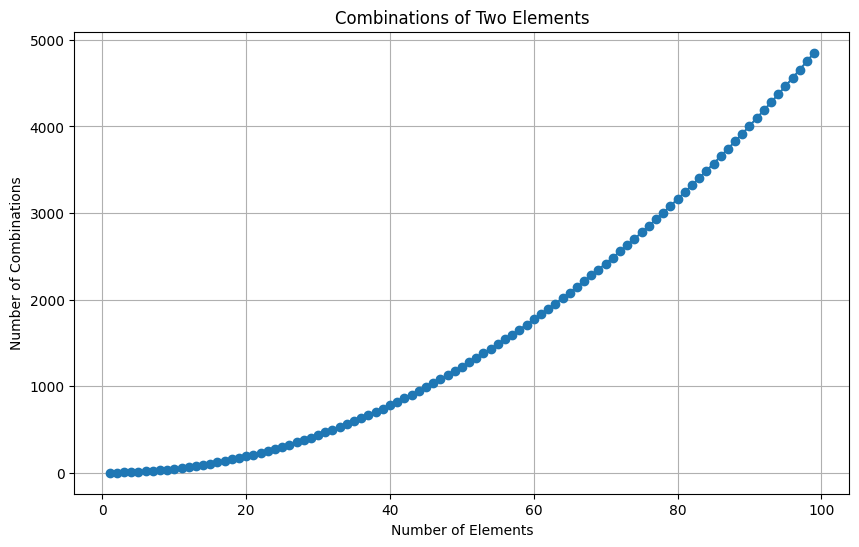

In [8]:
from scipy.special import comb

import matplotlib.pyplot as plt

# Define the range of elements
n_elements = range(1, 100)

# Calculate the number of combinations for each number of elements
n_combinations = [comb(n, 2, exact=True) for n in n_elements]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(n_elements, n_combinations, marker='o')
plt.xlabel('Number of Elements')
plt.ylabel('Number of Combinations')
plt.title('Combinations of Two Elements')
plt.grid(True)
plt.show()

## Read Files

In [9]:
from multiprocessing import Pool
import re


def read_json_file(file_path: str) -> Dict[str, Any]:
    with open(file_path, 'r') as file:
        data = json.load(file)
        data["error_file"] = os.path.basename(file_path)
        return data


def read_all_programs(dir_path: str) -> pd.DataFrame:
    json_files = [os.path.join(dir_path, f) for f in os.listdir(
        dir_path) if re.match(r'.*_error\.json$', f)]
    records = []

    with Pool() as pool:
        results = pool.map(read_json_file, json_files)
        records.extend(results)

    return pd.DataFrame(records)


# Use the function to read all programs
df_errors = read_all_programs(DIR_PROGRAM_BANK)

# augment the dataframe with the proram content


def read_file_content(file_name: str) -> str:
    file_path = os.path.join(DIR_PROGRAM_BANK, file_name)
    with open(file_path, 'r') as file:
        return file.read()


# Use parallel apply to read the file content
with Pool() as pool:
    df_errors['file_content'] = pool.map(
        read_file_content, df_errors['current_file'])

# Alternatively, you can use apply without parallel processing
# df_errors['file_content'] = df_errors['current_file'].apply(read_file_content)

df_errors.head()
n_errors = len(df_errors)
print(f"Number of errors: {n_errors}")


# HELPER FUNCTIONS


def get_corresponding_program_file(path_error_file: str) -> str:
    # remove the fixed length prefix "_ba6b02_error.json"
    return path_error_file[:-18] + ".py"


def copy_errors_to_sample_folder(
        sample_errors_paths: List[str],
        dir_sample_errors: str):
    os.makedirs(dir_sample_errors, exist_ok=True)
    for file_path in sample_errors_paths:
        shutil.copy(file_path, dir_sample_errors)
        print(f"Copying {file_path} to {dir_sample_errors}")
        corresponding_program_file = get_corresponding_program_file(file_path)
        shutil.copy(corresponding_program_file, dir_sample_errors)
        print(f"Copying {corresponding_program_file} to {dir_sample_errors}")

Number of errors: 7191


## Explore the error messages

# Exclude Pennylane (errors)

In [10]:
df_errors['involved_functions'] = df_errors['involved_functions'].astype(
    str)
df_errors = df_errors[
    ~df_errors['involved_functions'].str.contains('pennylane')]
n_errors = len(df_errors)
print(f"Number of errors without PennyLane: {n_errors}")

Number of errors without PennyLane: 8220


# Minimize Sample

In [ ]:

# keep only errors with `The circuits are not equivalent` in the exception message
df_errors = df_errors[df_errors['exception_message'].str.contains(
    'The circuits are not equivalent')]


SAMPLE_SIZE = 10
actual_sample_size = min(SAMPLE_SIZE, len(df_errors))


# pick a sample of error files
sample_errors = df_errors.sample(actual_sample_size, random_state=42)

# get the paths of the error files
sample_errors_paths = [os.path.join(
    DIR_PROGRAM_BANK, f) for f in sample_errors['error_file']]


copy_errors_to_sample_folder(sample_errors_paths, DIR_SAMPLE_ERRORS)

Copying ../program_bank/v009/2024_11_20__13_42__qiskit/qiskit_circuit_5q_10g_1511_600fe6_0353c4_error.json to ../program_bank/v009/2024_11_20__13_42__sample_errors_no_pennylane
Copying ../program_bank/v009/2024_11_20__13_42__qiskit/qiskit_circuit_5q_10g_1511_600fe6.py to ../program_bank/v009/2024_11_20__13_42__sample_errors_no_pennylane
Copying ../program_bank/v009/2024_11_20__13_42__qiskit/qiskit_circuit_5q_10g_5923_1fb05d_394db9_error.json to ../program_bank/v009/2024_11_20__13_42__sample_errors_no_pennylane
Copying ../program_bank/v009/2024_11_20__13_42__qiskit/qiskit_circuit_5q_10g_5923_1fb05d.py to ../program_bank/v009/2024_11_20__13_42__sample_errors_no_pennylane
Copying ../program_bank/v009/2024_11_20__13_42__qiskit/qiskit_circuit_5q_10g_5585_30abba_76b749_error.json to ../program_bank/v009/2024_11_20__13_42__sample_errors_no_pennylane
Copying ../program_bank/v009/2024_11_20__13_42__qiskit/qiskit_circuit_5q_10g_5585_30abba.py to ../program_bank/v009/2024_11_20__13_42__sample_err

In [11]:
# get the content of their error messages
sample_errors['exception_message']

12723    The circuits are not equivalent: /workspace/qi...
693      The circuits are not equivalent: /workspace/qi...
10624    The circuits are not equivalent: /workspace/qi...
3913     The circuits are not equivalent: /workspace/qi...
5149     The circuits are not equivalent: /workspace/qi...
11150    The circuits are not equivalent: /workspace/qi...
842      The circuits are not equivalent: /workspace/qi...
10721    The circuits are not equivalent: /workspace/qi...
11223    The circuits are not equivalent: /workspace/qi...
11601    The circuits are not equivalent: /workspace/qi...
Name: exception_message, dtype: object

In [30]:
import sys
sys.path.append("..")

## Triage All Files 
Including:
1. minimization
2. rerunning the code
3. running the analysis notebook

In [13]:
%load_ext autoreload
%autoreload 2

In [15]:
from analysis_and_reporting.triage import analyze_and_report

error_paths_in_sample_folder = [
    os.path.join(DIR_SAMPLE_ERRORS, f)
    for f in os.listdir(DIR_SAMPLE_ERRORS)
    if re.match(r'.*_error\.json$', f)
]

n_error_files = len(error_paths_in_sample_folder)
print(f"Error paths in sample folder ({n_error_files}):")
for error_path in error_paths_in_sample_folder:
    print(error_path)

# python -m analysis_and_reporting.triage --path_error_json program_bank/v007/2024_10_31__17_51__qiskit/qiskit_circuit_5q_10g_9_160f04_cfe9f1_error.json --parent_report_folder reports/v008 --clue_message 'not equivalent'


# def analyze_and_report(
#         path_error_json: str, path_program: str, parent_report_folder: str,
#         clue_message: str, analysis_notebook: str)

for error_path in error_paths_in_sample_folder:
    try:
        analyze_and_report(
            path_error_json=error_path,
            path_program=get_corresponding_program_file(error_path),
            parent_report_folder=os.path.join("..", "reports", "v009"),
            clue_message='not equivalent',
            analysis_notebook='010_Triage_Not_Equivalence.ipynb'
        )
    except Exception as e:
        print(f"Error: {e}")
        print("Skipping to the next error file")

Error paths in sample folder (10):
../program_bank/v009/2024_11_20__13_42__sample_errors_no_pennylane/qiskit_circuit_5q_10g_4342_faa083_a812bf_error.json
../program_bank/v009/2024_11_20__13_42__sample_errors_no_pennylane/qiskit_circuit_5q_10g_6316_146402_6a36f0_error.json
../program_bank/v009/2024_11_20__13_42__sample_errors_no_pennylane/qiskit_circuit_5q_10g_6533_f0b204_dbc69c_error.json
../program_bank/v009/2024_11_20__13_42__sample_errors_no_pennylane/qiskit_circuit_5q_10g_4756_28bbeb_444f6d_error.json
../program_bank/v009/2024_11_20__13_42__sample_errors_no_pennylane/qiskit_circuit_5q_10g_144_2ca34b_7b044a_error.json
../program_bank/v009/2024_11_20__13_42__sample_errors_no_pennylane/qiskit_circuit_5q_10g_680_6d896d_1fd766_error.json
../program_bank/v009/2024_11_20__13_42__sample_errors_no_pennylane/qiskit_circuit_5q_10g_5399_c4b732_f59bef_error.json
../program_bank/v009/2024_11_20__13_42__sample_errors_no_pennylane/qiskit_circuit_5q_10g_609_0c26d1_ee02f4_error.json
../program_bank/

[14:49:51] Created report folder: ../reports/v009/2024_11_21__14_49                                   ]8;id=600267;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py\triage.py]8;;\:]8;id=821025;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py#131\131]8;;\

           Copied files to: ../reports/v009/2024_11_21__14_49                                         ]8;id=566959;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py\triage.py]8;;\:]8;id=440829;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py#140\140]8;;\

[14:49:51] Involved functions:                                                             ]8;id=234626;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=101226;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#206\206]8;;\

             - compare_qasm_via_qcec                                                       ]8;id=317805;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=556817;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#208\208]8;;\

             - export_to_qasm_with_pytket                                                  ]8;id=139734;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=129989;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#208\208]8;;\

             - export_to_qasm_with_qiskit                                                  ]8;id=515191;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=857541;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#208\208]8;;\

Error parsing: Command 'python /workspace/to_execute.py' in image 'qiskit_runner' returned non-zero exit status 1: b'Traceback (most recent call last):\n  File "/workspace/to_execute.py", line 105, in <module>\n    target_qc = qc\nNameError: name \'qc\' is not defined\n'
Failed to execute to_execute.py in Docker.
Output: Saved the Pytket circuit to /workspace/to_execute_qc_pytket.qasm
Saved the Qiskit circuit to /workspace/to_execute_qc_qiskit.qasm
Exported QASM files: [('/workspace/to_execute_qc_pytket.qasm', 'export_to_qasm_with_pytket'), ('/workspace/to_execute_qc_qiskit.qasm', 'export_to_qasm_with_qiskit')]
Log has been saved to /workspace/to_execute_cb5d12_error.json

Program to_execute.py executed successfully.
New exception message: The circuits are not equivalent: /workspace/to_execute_qc_pytket.qasm, /workspace/to_execute_qc_qiskit.qasm
Error parsing: Command 'python /workspace/to_execute.py' in image 'qiskit_runner' returned non-zero exit status 1: b'  File "/workspace/to_exe

[14:53:11] Minimized file saved as:                                                        ]8;id=70170;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=745287;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#240\240]8;;\
           ../reports/v009/2024_11_21__14_49/qiskit_circuit_5q_10g_4342_faa083_a812bf_erro                         
           r_min.py                                                                                                

Output: Saved the Pytket circuit to /workspace/qiskit_circuit_5q_10g_4342_faa083_a812bf_error_min_qc_pytket.qasm
Saved the Qiskit circuit to /workspace/qiskit_circuit_5q_10g_4342_faa083_a812bf_error_min_qc_qiskit.qasm
Exported QASM files: [('/workspace/qiskit_circuit_5q_10g_4342_faa083_a812bf_error_min_qc_pytket.qasm', 'export_to_qasm_with_pytket'), ('/workspace/qiskit_circuit_5q_10g_4342_faa083_a812bf_error_min_qc_qiskit.qasm', 'export_to_qasm_with_qiskit')]
Log has been saved to /workspace/qiskit_circuit_5q_10g_4342_faa083_a812bf_error_min_577bf2_error.json



[14:53:18] Program qiskit_circuit_5q_10g_4342_faa083_a812bf_error_min.py executed              ]8;id=28932;file:///home/paltenmo/projects/crossplatform/generators/docker_tooling.py\docker_tooling.py]8;;\:]8;id=575837;file:///home/paltenmo/projects/crossplatform/generators/docker_tooling.py#46\46]8;;\
           successfully.                                                                                           

Executing:   0%|          | 0/13 [00:00<?, ?cell/s]

[14:53:21] Analysis notebook executed: ../reports/v009/2024_11_21__14_49/analysis_output.ipynb        ]8;id=599315;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py\triage.py]8;;\:]8;id=886792;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py#163\163]8;;\

           Created report folder: ../reports/v009/2024_11_21__14_53                                   ]8;id=219138;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py\triage.py]8;;\:]8;id=604296;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py#131\131]8;;\

           Copied files to: ../reports/v009/2024_11_21__14_53                                         ]8;id=694511;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py\triage.py]8;;\:]8;id=600508;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py#140\140]8;;\

[14:53:21] Involved functions:                                                             ]8;id=827893;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=760556;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#206\206]8;;\

             - compare_qasm_via_qcec                                                       ]8;id=664975;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=821106;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#208\208]8;;\

             - export_to_qasm_with_pytket                                                  ]8;id=469393;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=635034;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#208\208]8;;\

             - export_to_qasm_with_qiskit                                                  ]8;id=738724;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=822888;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#208\208]8;;\

Error parsing: Command 'python /workspace/to_execute.py' in image 'qiskit_runner' returned non-zero exit status 1: b'Traceback (most recent call last):\n  File "/workspace/to_execute.py", line 105, in <module>\n    target_qc = qc\nNameError: name \'qc\' is not defined\n'
Failed to execute to_execute.py in Docker.
Output: Saved the Pytket circuit to /workspace/to_execute_qc_pytket.qasm
Saved the Qiskit circuit to /workspace/to_execute_qc_qiskit.qasm
Exported QASM files: [('/workspace/to_execute_qc_pytket.qasm', 'export_to_qasm_with_pytket'), ('/workspace/to_execute_qc_qiskit.qasm', 'export_to_qasm_with_qiskit')]
Log has been saved to /workspace/to_execute_c30ec3_error.json

Program to_execute.py executed successfully.
New exception message: The circuits are not equivalent: /workspace/to_execute_qc_pytket.qasm, /workspace/to_execute_qc_qiskit.qasm
Error parsing: Command 'python /workspace/to_execute.py' in image 'qiskit_runner' returned non-zero exit status 1: b'  File "/workspace/to_exe

[14:57:17] Minimized file saved as:                                                        ]8;id=692249;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=195353;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#240\240]8;;\
           ../reports/v009/2024_11_21__14_53/qiskit_circuit_5q_10g_6316_146402_6a36f0_erro                         
           r_min.py                                                                                                

Output: Saved the Pytket circuit to /workspace/qiskit_circuit_5q_10g_6316_146402_6a36f0_error_min_qc_pytket.qasm
Saved the Qiskit circuit to /workspace/qiskit_circuit_5q_10g_6316_146402_6a36f0_error_min_qc_qiskit.qasm
Exported QASM files: [('/workspace/qiskit_circuit_5q_10g_6316_146402_6a36f0_error_min_qc_pytket.qasm', 'export_to_qasm_with_pytket'), ('/workspace/qiskit_circuit_5q_10g_6316_146402_6a36f0_error_min_qc_qiskit.qasm', 'export_to_qasm_with_qiskit')]
Log has been saved to /workspace/qiskit_circuit_5q_10g_6316_146402_6a36f0_error_min_c55469_error.json



[14:57:24] Program qiskit_circuit_5q_10g_6316_146402_6a36f0_error_min.py executed              ]8;id=784739;file:///home/paltenmo/projects/crossplatform/generators/docker_tooling.py\docker_tooling.py]8;;\:]8;id=128634;file:///home/paltenmo/projects/crossplatform/generators/docker_tooling.py#46\46]8;;\
           successfully.                                                                                           

Executing:   0%|          | 0/13 [00:00<?, ?cell/s]

[14:57:26] Analysis notebook executed: ../reports/v009/2024_11_21__14_53/analysis_output.ipynb        ]8;id=472223;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py\triage.py]8;;\:]8;id=260868;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py#163\163]8;;\

           Created report folder: ../reports/v009/2024_11_21__14_57                                   ]8;id=630748;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py\triage.py]8;;\:]8;id=541353;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py#131\131]8;;\

           Copied files to: ../reports/v009/2024_11_21__14_57                                         ]8;id=991224;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py\triage.py]8;;\:]8;id=138808;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py#140\140]8;;\

[14:57:26] Involved functions:                                                             ]8;id=833856;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=305986;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#206\206]8;;\

             - compare_qasm_via_qcec                                                       ]8;id=409146;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=978736;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#208\208]8;;\

             - export_to_qasm_with_pytket                                                  ]8;id=669945;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=378051;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#208\208]8;;\

             - export_to_qasm_with_qiskit                                                  ]8;id=829317;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=334716;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#208\208]8;;\

Error parsing: Command 'python /workspace/to_execute.py' in image 'qiskit_runner' returned non-zero exit status 1: b'Traceback (most recent call last):\n  File "/workspace/to_execute.py", line 105, in <module>\n    target_qc = qc\nNameError: name \'qc\' is not defined\n'
Failed to execute to_execute.py in Docker.
Output: Saved the Pytket circuit to /workspace/to_execute_qc_pytket.qasm
Saved the Qiskit circuit to /workspace/to_execute_qc_qiskit.qasm
Exported QASM files: [('/workspace/to_execute_qc_pytket.qasm', 'export_to_qasm_with_pytket'), ('/workspace/to_execute_qc_qiskit.qasm', 'export_to_qasm_with_qiskit')]
Log has been saved to /workspace/to_execute_880d95_error.json

Program to_execute.py executed successfully.
New exception message: The circuits are not equivalent: /workspace/to_execute_qc_pytket.qasm, /workspace/to_execute_qc_qiskit.qasm
Error parsing: Command 'python /workspace/to_execute.py' in image 'qiskit_runner' returned non-zero exit status 1: b'  File "/workspace/to_exe

[15:01:35] Minimized file saved as:                                                        ]8;id=330228;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=890946;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#240\240]8;;\
           ../reports/v009/2024_11_21__14_57/qiskit_circuit_5q_10g_6533_f0b204_dbc69c_erro                         
           r_min.py                                                                                                

Output: Saved the Pytket circuit to /workspace/qiskit_circuit_5q_10g_6533_f0b204_dbc69c_error_min_qc_pytket.qasm
Saved the Qiskit circuit to /workspace/qiskit_circuit_5q_10g_6533_f0b204_dbc69c_error_min_qc_qiskit.qasm
Exported QASM files: [('/workspace/qiskit_circuit_5q_10g_6533_f0b204_dbc69c_error_min_qc_pytket.qasm', 'export_to_qasm_with_pytket'), ('/workspace/qiskit_circuit_5q_10g_6533_f0b204_dbc69c_error_min_qc_qiskit.qasm', 'export_to_qasm_with_qiskit')]
Log has been saved to /workspace/qiskit_circuit_5q_10g_6533_f0b204_dbc69c_error_min_dc03a6_error.json



[15:01:42] Program qiskit_circuit_5q_10g_6533_f0b204_dbc69c_error_min.py executed              ]8;id=496062;file:///home/paltenmo/projects/crossplatform/generators/docker_tooling.py\docker_tooling.py]8;;\:]8;id=906562;file:///home/paltenmo/projects/crossplatform/generators/docker_tooling.py#46\46]8;;\
           successfully.                                                                                           

Executing:   0%|          | 0/13 [00:00<?, ?cell/s]

[15:01:45] Analysis notebook executed: ../reports/v009/2024_11_21__14_57/analysis_output.ipynb        ]8;id=838500;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py\triage.py]8;;\:]8;id=187327;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py#163\163]8;;\

           Created report folder: ../reports/v009/2024_11_21__15_01                                   ]8;id=983100;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py\triage.py]8;;\:]8;id=686809;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py#131\131]8;;\

           Copied files to: ../reports/v009/2024_11_21__15_01                                         ]8;id=61401;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py\triage.py]8;;\:]8;id=451277;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py#140\140]8;;\

[15:01:45] Involved functions:                                                             ]8;id=393739;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=121612;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#206\206]8;;\

             - compare_qasm_via_qcec                                                       ]8;id=893171;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=900657;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#208\208]8;;\

             - export_to_qasm_with_pytket                                                  ]8;id=482258;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=444501;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#208\208]8;;\

             - export_to_qasm_with_qiskit                                                  ]8;id=403788;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=219130;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#208\208]8;;\

Error parsing: Command 'python /workspace/to_execute.py' in image 'qiskit_runner' returned non-zero exit status 1: b'Traceback (most recent call last):\n  File "/workspace/to_execute.py", line 105, in <module>\n    target_qc = qc\nNameError: name \'qc\' is not defined\n'
Failed to execute to_execute.py in Docker.
Output: Saved the Pytket circuit to /workspace/to_execute_qc_pytket.qasm
Saved the Qiskit circuit to /workspace/to_execute_qc_qiskit.qasm
Exported QASM files: [('/workspace/to_execute_qc_pytket.qasm', 'export_to_qasm_with_pytket'), ('/workspace/to_execute_qc_qiskit.qasm', 'export_to_qasm_with_qiskit')]
Log has been saved to /workspace/to_execute_81243d_error.json

Program to_execute.py executed successfully.
New exception message: The circuits are not equivalent: /workspace/to_execute_qc_pytket.qasm, /workspace/to_execute_qc_qiskit.qasm
Error parsing: Command 'python /workspace/to_execute.py' in image 'qiskit_runner' returned non-zero exit status 1: b'  File "/workspace/to_exe

[15:05:37] Minimized file saved as:                                                        ]8;id=374591;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=992044;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#240\240]8;;\
           ../reports/v009/2024_11_21__15_01/qiskit_circuit_5q_10g_4756_28bbeb_444f6d_erro                         
           r_min.py                                                                                                

Output: Saved the Pytket circuit to /workspace/qiskit_circuit_5q_10g_4756_28bbeb_444f6d_error_min_qc_pytket.qasm
Saved the Qiskit circuit to /workspace/qiskit_circuit_5q_10g_4756_28bbeb_444f6d_error_min_qc_qiskit.qasm
Exported QASM files: [('/workspace/qiskit_circuit_5q_10g_4756_28bbeb_444f6d_error_min_qc_pytket.qasm', 'export_to_qasm_with_pytket'), ('/workspace/qiskit_circuit_5q_10g_4756_28bbeb_444f6d_error_min_qc_qiskit.qasm', 'export_to_qasm_with_qiskit')]
Log has been saved to /workspace/qiskit_circuit_5q_10g_4756_28bbeb_444f6d_error_min_f825ac_error.json



[15:05:44] Program qiskit_circuit_5q_10g_4756_28bbeb_444f6d_error_min.py executed              ]8;id=433034;file:///home/paltenmo/projects/crossplatform/generators/docker_tooling.py\docker_tooling.py]8;;\:]8;id=249443;file:///home/paltenmo/projects/crossplatform/generators/docker_tooling.py#46\46]8;;\
           successfully.                                                                                           

Executing:   0%|          | 0/13 [00:00<?, ?cell/s]

[15:05:47] Analysis notebook executed: ../reports/v009/2024_11_21__15_01/analysis_output.ipynb        ]8;id=422346;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py\triage.py]8;;\:]8;id=756250;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py#163\163]8;;\

           Created report folder: ../reports/v009/2024_11_21__15_05                                   ]8;id=665387;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py\triage.py]8;;\:]8;id=876487;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py#131\131]8;;\

           Copied files to: ../reports/v009/2024_11_21__15_05                                         ]8;id=646824;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py\triage.py]8;;\:]8;id=991856;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py#140\140]8;;\

[15:05:47] Involved functions:                                                             ]8;id=436472;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=693447;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#206\206]8;;\

             - compare_qasm_via_qcec                                                       ]8;id=2387;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=272413;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#208\208]8;;\

             - export_to_qasm_with_pytket                                                  ]8;id=543962;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=975384;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#208\208]8;;\

             - export_to_qasm_with_qiskit                                                  ]8;id=819219;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=873876;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#208\208]8;;\

Error parsing: Command 'python /workspace/to_execute.py' in image 'qiskit_runner' returned non-zero exit status 1: b'Traceback (most recent call last):\n  File "/workspace/to_execute.py", line 105, in <module>\n    target_qc = qc\nNameError: name \'qc\' is not defined\n'
Failed to execute to_execute.py in Docker.
Output: Saved the Pytket circuit to /workspace/to_execute_qc_pytket.qasm
Saved the Qiskit circuit to /workspace/to_execute_qc_qiskit.qasm
Exported QASM files: [('/workspace/to_execute_qc_pytket.qasm', 'export_to_qasm_with_pytket'), ('/workspace/to_execute_qc_qiskit.qasm', 'export_to_qasm_with_qiskit')]
Log has been saved to /workspace/to_execute_e6b864_error.json

Program to_execute.py executed successfully.
New exception message: The circuits are not equivalent: /workspace/to_execute_qc_pytket.qasm, /workspace/to_execute_qc_qiskit.qasm
Error parsing: Command 'python /workspace/to_execute.py' in image 'qiskit_runner' returned non-zero exit status 1: b'  File "/workspace/to_exe

[15:09:16] Minimized file saved as:                                                        ]8;id=39106;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=760733;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#240\240]8;;\
           ../reports/v009/2024_11_21__15_05/qiskit_circuit_5q_10g_144_2ca34b_7b044a_error                         
           _min.py                                                                                                 

Output: Saved the Pytket circuit to /workspace/qiskit_circuit_5q_10g_144_2ca34b_7b044a_error_min_qc_pytket.qasm
Saved the Qiskit circuit to /workspace/qiskit_circuit_5q_10g_144_2ca34b_7b044a_error_min_qc_qiskit.qasm
Exported QASM files: [('/workspace/qiskit_circuit_5q_10g_144_2ca34b_7b044a_error_min_qc_pytket.qasm', 'export_to_qasm_with_pytket'), ('/workspace/qiskit_circuit_5q_10g_144_2ca34b_7b044a_error_min_qc_qiskit.qasm', 'export_to_qasm_with_qiskit')]
Log has been saved to /workspace/qiskit_circuit_5q_10g_144_2ca34b_7b044a_error_min_c118ed_error.json



[15:09:23] Program qiskit_circuit_5q_10g_144_2ca34b_7b044a_error_min.py executed successfully. ]8;id=30161;file:///home/paltenmo/projects/crossplatform/generators/docker_tooling.py\docker_tooling.py]8;;\:]8;id=40729;file:///home/paltenmo/projects/crossplatform/generators/docker_tooling.py#46\46]8;;\

Executing:   0%|          | 0/13 [00:00<?, ?cell/s]

[15:09:27] Analysis notebook executed: ../reports/v009/2024_11_21__15_05/analysis_output.ipynb        ]8;id=753026;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py\triage.py]8;;\:]8;id=206102;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py#163\163]8;;\

           Created report folder: ../reports/v009/2024_11_21__15_09                                   ]8;id=293035;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py\triage.py]8;;\:]8;id=946181;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py#131\131]8;;\

           Copied files to: ../reports/v009/2024_11_21__15_09                                         ]8;id=868518;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py\triage.py]8;;\:]8;id=330998;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py#140\140]8;;\

[15:09:27] Involved functions:                                                             ]8;id=923228;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=342367;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#206\206]8;;\

             - compare_qasm_via_qcec                                                       ]8;id=345369;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=639561;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#208\208]8;;\

             - export_to_qasm_with_pytket                                                  ]8;id=697834;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=911757;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#208\208]8;;\

             - export_to_qasm_with_qiskit                                                  ]8;id=560456;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=365804;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#208\208]8;;\

Error parsing: Command 'python /workspace/to_execute.py' in image 'qiskit_runner' returned non-zero exit status 1: b'Traceback (most recent call last):\n  File "/workspace/to_execute.py", line 105, in <module>\n    target_qc = qc\nNameError: name \'qc\' is not defined\n'
Failed to execute to_execute.py in Docker.
Output: Saved the Pytket circuit to /workspace/to_execute_qc_pytket.qasm
Saved the Qiskit circuit to /workspace/to_execute_qc_qiskit.qasm
Exported QASM files: [('/workspace/to_execute_qc_pytket.qasm', 'export_to_qasm_with_pytket'), ('/workspace/to_execute_qc_qiskit.qasm', 'export_to_qasm_with_qiskit')]
Log has been saved to /workspace/to_execute_8f8f09_error.json

Program to_execute.py executed successfully.
New exception message: The circuits are not equivalent: /workspace/to_execute_qc_pytket.qasm, /workspace/to_execute_qc_qiskit.qasm
Error parsing: Command 'python /workspace/to_execute.py' in image 'qiskit_runner' returned non-zero exit status 1: b'  File "/workspace/to_exe

[15:12:24] Minimized file saved as:                                                        ]8;id=925058;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=911043;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#240\240]8;;\
           ../reports/v009/2024_11_21__15_09/qiskit_circuit_5q_10g_680_6d896d_1fd766_error                         
           _min.py                                                                                                 

Output: Saved the Pytket circuit to /workspace/qiskit_circuit_5q_10g_680_6d896d_1fd766_error_min_qc_pytket.qasm
Saved the Qiskit circuit to /workspace/qiskit_circuit_5q_10g_680_6d896d_1fd766_error_min_qc_qiskit.qasm
Exported QASM files: [('/workspace/qiskit_circuit_5q_10g_680_6d896d_1fd766_error_min_qc_pytket.qasm', 'export_to_qasm_with_pytket'), ('/workspace/qiskit_circuit_5q_10g_680_6d896d_1fd766_error_min_qc_qiskit.qasm', 'export_to_qasm_with_qiskit')]
Log has been saved to /workspace/qiskit_circuit_5q_10g_680_6d896d_1fd766_error_min_c3fa11_error.json



[15:12:31] Program qiskit_circuit_5q_10g_680_6d896d_1fd766_error_min.py executed successfully. ]8;id=477414;file:///home/paltenmo/projects/crossplatform/generators/docker_tooling.py\docker_tooling.py]8;;\:]8;id=213744;file:///home/paltenmo/projects/crossplatform/generators/docker_tooling.py#46\46]8;;\

Executing:   0%|          | 0/13 [00:00<?, ?cell/s]

[15:12:34] Analysis notebook executed: ../reports/v009/2024_11_21__15_09/analysis_output.ipynb        ]8;id=672233;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py\triage.py]8;;\:]8;id=4561;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py#163\163]8;;\

           Created report folder: ../reports/v009/2024_11_21__15_12                                   ]8;id=539788;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py\triage.py]8;;\:]8;id=237902;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py#131\131]8;;\

           Copied files to: ../reports/v009/2024_11_21__15_12                                         ]8;id=440474;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py\triage.py]8;;\:]8;id=45501;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py#140\140]8;;\

[15:12:34] Involved functions:                                                             ]8;id=551201;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=250080;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#206\206]8;;\

             - compare_qasm_via_qcec                                                       ]8;id=263622;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=456243;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#208\208]8;;\

             - export_to_qasm_with_pytket                                                  ]8;id=634482;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=715175;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#208\208]8;;\

             - export_to_qasm_with_qiskit                                                  ]8;id=208365;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=926996;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#208\208]8;;\

Error parsing: Command 'python /workspace/to_execute.py' in image 'qiskit_runner' returned non-zero exit status 1: b'Traceback (most recent call last):\n  File "/workspace/to_execute.py", line 105, in <module>\n    target_qc = qc\nNameError: name \'qc\' is not defined\n'
Failed to execute to_execute.py in Docker.
Output: Saved the Pytket circuit to /workspace/to_execute_qc_pytket.qasm
Saved the Qiskit circuit to /workspace/to_execute_qc_qiskit.qasm
Exported QASM files: [('/workspace/to_execute_qc_pytket.qasm', 'export_to_qasm_with_pytket'), ('/workspace/to_execute_qc_qiskit.qasm', 'export_to_qasm_with_qiskit')]
Log has been saved to /workspace/to_execute_d9884e_error.json

Program to_execute.py executed successfully.
New exception message: The circuits are not equivalent: /workspace/to_execute_qc_pytket.qasm, /workspace/to_execute_qc_qiskit.qasm
Error parsing: Command 'python /workspace/to_execute.py' in image 'qiskit_runner' returned non-zero exit status 1: b'  File "/workspace/to_exe

[15:15:46] Minimized file saved as:                                                        ]8;id=979709;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=722071;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#240\240]8;;\
           ../reports/v009/2024_11_21__15_12/qiskit_circuit_5q_10g_5399_c4b732_f59bef_erro                         
           r_min.py                                                                                                

Output: Saved the Pytket circuit to /workspace/qiskit_circuit_5q_10g_5399_c4b732_f59bef_error_min_qc_pytket.qasm
Saved the Qiskit circuit to /workspace/qiskit_circuit_5q_10g_5399_c4b732_f59bef_error_min_qc_qiskit.qasm
Exported QASM files: [('/workspace/qiskit_circuit_5q_10g_5399_c4b732_f59bef_error_min_qc_pytket.qasm', 'export_to_qasm_with_pytket'), ('/workspace/qiskit_circuit_5q_10g_5399_c4b732_f59bef_error_min_qc_qiskit.qasm', 'export_to_qasm_with_qiskit')]
Log has been saved to /workspace/qiskit_circuit_5q_10g_5399_c4b732_f59bef_error_min_ecf2b2_error.json



[15:15:53] Program qiskit_circuit_5q_10g_5399_c4b732_f59bef_error_min.py executed              ]8;id=874944;file:///home/paltenmo/projects/crossplatform/generators/docker_tooling.py\docker_tooling.py]8;;\:]8;id=661643;file:///home/paltenmo/projects/crossplatform/generators/docker_tooling.py#46\46]8;;\
           successfully.                                                                                           

Executing:   0%|          | 0/13 [00:00<?, ?cell/s]

[15:15:56] Analysis notebook executed: ../reports/v009/2024_11_21__15_12/analysis_output.ipynb        ]8;id=117710;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py\triage.py]8;;\:]8;id=465129;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py#163\163]8;;\

           Created report folder: ../reports/v009/2024_11_21__15_15                                   ]8;id=102550;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py\triage.py]8;;\:]8;id=719536;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py#131\131]8;;\

           Copied files to: ../reports/v009/2024_11_21__15_15                                         ]8;id=254451;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py\triage.py]8;;\:]8;id=924520;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py#140\140]8;;\

[15:15:56] Involved functions:                                                             ]8;id=157722;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=705551;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#206\206]8;;\

             - compare_qasm_via_qcec                                                       ]8;id=791955;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=608482;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#208\208]8;;\

             - export_to_qasm_with_bqskit                                                  ]8;id=10425;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=282882;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#208\208]8;;\

[15:15:57]   - export_to_qasm_with_pytket                                                  ]8;id=550352;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=158406;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#208\208]8;;\

Error parsing: Command 'python /workspace/to_execute.py' in image 'qiskit_runner' returned non-zero exit status 1: b'Traceback (most recent call last):\n  File "/workspace/to_execute.py", line 106, in <module>\n    target_qc = qc\nNameError: name \'qc\' is not defined\n'
Failed to execute to_execute.py in Docker.
Output: Saved the BQSKit circuit to /workspace/to_execute_qc_bqskit.qasm
Saved the Pytket circuit to /workspace/to_execute_qc_pytket.qasm
Exported QASM files: [('/workspace/to_execute_qc_bqskit.qasm', 'export_to_qasm_with_bqskit'), ('/workspace/to_execute_qc_pytket.qasm', 'export_to_qasm_with_pytket')]
Log has been saved to /workspace/to_execute_1be6f2_error.json

Program to_execute.py executed successfully.
New exception message: The circuits are not equivalent: /workspace/to_execute_qc_bqskit.qasm, /workspace/to_execute_qc_pytket.qasm
Error parsing: Command 'python /workspace/to_execute.py' in image 'qiskit_runner' returned non-zero exit status 1: b'  File "/workspace/to_exe

[15:19:58] Minimized file saved as:                                                        ]8;id=705857;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=577998;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#240\240]8;;\
           ../reports/v009/2024_11_21__15_15/qiskit_circuit_5q_10g_609_0c26d1_ee02f4_error                         
           _min.py                                                                                                 

Output: Saved the BQSKit circuit to /workspace/qiskit_circuit_5q_10g_609_0c26d1_ee02f4_error_min_qc_bqskit.qasm
Saved the Pytket circuit to /workspace/qiskit_circuit_5q_10g_609_0c26d1_ee02f4_error_min_qc_pytket.qasm
Exported QASM files: [('/workspace/qiskit_circuit_5q_10g_609_0c26d1_ee02f4_error_min_qc_bqskit.qasm', 'export_to_qasm_with_bqskit'), ('/workspace/qiskit_circuit_5q_10g_609_0c26d1_ee02f4_error_min_qc_pytket.qasm', 'export_to_qasm_with_pytket')]
Log has been saved to /workspace/qiskit_circuit_5q_10g_609_0c26d1_ee02f4_error_min_fefa9c_error.json



[15:20:05] Program qiskit_circuit_5q_10g_609_0c26d1_ee02f4_error_min.py executed successfully. ]8;id=278372;file:///home/paltenmo/projects/crossplatform/generators/docker_tooling.py\docker_tooling.py]8;;\:]8;id=644727;file:///home/paltenmo/projects/crossplatform/generators/docker_tooling.py#46\46]8;;\

Executing:   0%|          | 0/13 [00:00<?, ?cell/s]

[15:20:08] Analysis notebook executed: ../reports/v009/2024_11_21__15_15/analysis_output.ipynb        ]8;id=329862;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py\triage.py]8;;\:]8;id=553211;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py#163\163]8;;\

           Created report folder: ../reports/v009/2024_11_21__15_20                                   ]8;id=15674;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py\triage.py]8;;\:]8;id=699119;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py#131\131]8;;\

           Copied files to: ../reports/v009/2024_11_21__15_20                                         ]8;id=965951;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py\triage.py]8;;\:]8;id=640382;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py#140\140]8;;\

[15:20:08] Involved functions:                                                             ]8;id=308250;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=994586;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#206\206]8;;\

             - compare_qasm_via_qcec                                                       ]8;id=221735;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=671155;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#208\208]8;;\

             - export_to_qasm_with_bqskit                                                  ]8;id=698568;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=544819;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#208\208]8;;\

             - export_to_qasm_with_pytket                                                  ]8;id=663922;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=494599;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#208\208]8;;\

Error parsing: Command 'python /workspace/to_execute.py' in image 'qiskit_runner' returned non-zero exit status 1: b'Traceback (most recent call last):\n  File "/workspace/to_execute.py", line 106, in <module>\n    target_qc = qc\nNameError: name \'qc\' is not defined\n'
Failed to execute to_execute.py in Docker.
Output: Saved the BQSKit circuit to /workspace/to_execute_qc_bqskit.qasm
Saved the Pytket circuit to /workspace/to_execute_qc_pytket.qasm
Exported QASM files: [('/workspace/to_execute_qc_bqskit.qasm', 'export_to_qasm_with_bqskit'), ('/workspace/to_execute_qc_pytket.qasm', 'export_to_qasm_with_pytket')]
Log has been saved to /workspace/to_execute_17ef87_error.json

Program to_execute.py executed successfully.
New exception message: The circuits are not equivalent: /workspace/to_execute_qc_bqskit.qasm, /workspace/to_execute_qc_pytket.qasm
Error parsing: Command 'python /workspace/to_execute.py' in image 'qiskit_runner' returned non-zero exit status 1: b'  File "/workspace/to_exe

[15:23:48] Minimized file saved as:                                                        ]8;id=23267;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=35295;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#240\240]8;;\
           ../reports/v009/2024_11_21__15_20/qiskit_circuit_5q_10g_650_4493c8_a271e3_error                         
           _min.py                                                                                                 

Output: Saved the BQSKit circuit to /workspace/qiskit_circuit_5q_10g_650_4493c8_a271e3_error_min_qc_bqskit.qasm
Saved the Pytket circuit to /workspace/qiskit_circuit_5q_10g_650_4493c8_a271e3_error_min_qc_pytket.qasm
Exported QASM files: [('/workspace/qiskit_circuit_5q_10g_650_4493c8_a271e3_error_min_qc_bqskit.qasm', 'export_to_qasm_with_bqskit'), ('/workspace/qiskit_circuit_5q_10g_650_4493c8_a271e3_error_min_qc_pytket.qasm', 'export_to_qasm_with_pytket')]
Log has been saved to /workspace/qiskit_circuit_5q_10g_650_4493c8_a271e3_error_min_47549b_error.json



[15:23:55] Program qiskit_circuit_5q_10g_650_4493c8_a271e3_error_min.py executed successfully. ]8;id=382553;file:///home/paltenmo/projects/crossplatform/generators/docker_tooling.py\docker_tooling.py]8;;\:]8;id=189236;file:///home/paltenmo/projects/crossplatform/generators/docker_tooling.py#46\46]8;;\

Executing:   0%|          | 0/13 [00:00<?, ?cell/s]

[15:23:58] Analysis notebook executed: ../reports/v009/2024_11_21__15_20/analysis_output.ipynb        ]8;id=657687;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py\triage.py]8;;\:]8;id=90175;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py#163\163]8;;\

           Created report folder: ../reports/v009/2024_11_21__15_23                                   ]8;id=436416;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py\triage.py]8;;\:]8;id=622083;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py#131\131]8;;\

           Copied files to: ../reports/v009/2024_11_21__15_23                                         ]8;id=507940;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py\triage.py]8;;\:]8;id=690126;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py#140\140]8;;\

[15:23:58] Involved functions:                                                             ]8;id=648791;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=867010;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#206\206]8;;\

             - compare_qasm_via_qcec                                                       ]8;id=128903;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=262494;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#208\208]8;;\

             - export_to_qasm_with_pytket                                                  ]8;id=130607;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=854269;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#208\208]8;;\

             - export_to_qasm_with_qiskit                                                  ]8;id=710345;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=164765;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#208\208]8;;\

Error parsing: Command 'python /workspace/to_execute.py' in image 'qiskit_runner' returned non-zero exit status 1: b'Traceback (most recent call last):\n  File "/workspace/to_execute.py", line 105, in <module>\n    target_qc = qc\nNameError: name \'qc\' is not defined\n'
Failed to execute to_execute.py in Docker.
Output: Saved the Pytket circuit to /workspace/to_execute_qc_pytket.qasm
Saved the Qiskit circuit to /workspace/to_execute_qc_qiskit.qasm
Exported QASM files: [('/workspace/to_execute_qc_pytket.qasm', 'export_to_qasm_with_pytket'), ('/workspace/to_execute_qc_qiskit.qasm', 'export_to_qasm_with_qiskit')]
Log has been saved to /workspace/to_execute_20d2d1_error.json

Program to_execute.py executed successfully.
New exception message: The circuits are not equivalent: /workspace/to_execute_qc_pytket.qasm, /workspace/to_execute_qc_qiskit.qasm
Error parsing: Command 'python /workspace/to_execute.py' in image 'qiskit_runner' returned non-zero exit status 1: b'  File "/workspace/to_exe

[15:27:12] Minimized file saved as:                                                        ]8;id=250509;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=510256;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#240\240]8;;\
           ../reports/v009/2024_11_21__15_23/qiskit_circuit_5q_10g_2997_458c2e_f885b3_erro                         
           r_min.py                                                                                                

Output: Saved the Pytket circuit to /workspace/qiskit_circuit_5q_10g_2997_458c2e_f885b3_error_min_qc_pytket.qasm
Saved the Qiskit circuit to /workspace/qiskit_circuit_5q_10g_2997_458c2e_f885b3_error_min_qc_qiskit.qasm
Exported QASM files: [('/workspace/qiskit_circuit_5q_10g_2997_458c2e_f885b3_error_min_qc_pytket.qasm', 'export_to_qasm_with_pytket'), ('/workspace/qiskit_circuit_5q_10g_2997_458c2e_f885b3_error_min_qc_qiskit.qasm', 'export_to_qasm_with_qiskit')]
Log has been saved to /workspace/qiskit_circuit_5q_10g_2997_458c2e_f885b3_error_min_da3a45_error.json



[15:27:18] Program qiskit_circuit_5q_10g_2997_458c2e_f885b3_error_min.py executed              ]8;id=134878;file:///home/paltenmo/projects/crossplatform/generators/docker_tooling.py\docker_tooling.py]8;;\:]8;id=151265;file:///home/paltenmo/projects/crossplatform/generators/docker_tooling.py#46\46]8;;\
           successfully.                                                                                           

Executing:   0%|          | 0/13 [00:00<?, ?cell/s]

[15:27:21] Analysis notebook executed: ../reports/v009/2024_11_21__15_23/analysis_output.ipynb        ]8;id=463065;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py\triage.py]8;;\:]8;id=328971;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py#163\163]8;;\

# Inspect Crash Errors

In [7]:
# ! pip install datasets

In [10]:
df_errors.head()

,exception_message,stack_trace,current_file,involved_functions,timestamp,extra_info,error_file,file_content
0,Operation MidMeasureMP not supported by the QA...,"Traceback (most recent call last):\n File ""/u...",0000627_17521c.py,"[from_qiskit, optimize_with_pennylane]",1.738240e+09,None,0000627_17521c_558ecb_error.json,# Section: Prologue\nfrom qiskit import Quantu...
1,Operation QubitUnitary not supported by the QA...,"Traceback (most recent call last):\n File ""/u...",0000442_969ce4.py,"[import_from_qasm_with_pennylane, export_to_qa...",1.738238e+09,{'input_qasm_file': '0000442_969ce4_qc_opt_lev...,0000442_969ce4_9e0c5a_error.json,# Section: Prologue\nfrom qiskit import Quantu...
2,Operation MidMeasureMP not supported by the QA...,"Traceback (most recent call last):\n File ""/u...",0000146_e3c863.py,"[from_qiskit, optimize_with_pennylane]",1.738236e+09,None,0000146_e3c863_42eb88_error.json,# Section: Prologue\nfrom qiskit import Quantu...
3,Conversion of qiskit's dcx instruction is curr...,"Traceback (most recent call last):\n File ""/u...",0000995_77f00c.py,"[qiskit_to_tk, optimize_with_pytket]",1.738242e+09,None,0000995_77f00c_6e9522_error.json,# Section: Prologue\nfrom qiskit import Quantu...
4,Operation QubitUnitary not supported by the QA...,"Traceback (most recent call last):\n File ""/u...",0000390_133778.py,"[import_from_qasm_with_pennylane, export_to_qa...",1.738238e+09,{'input_qasm_file': '0000390_133778_qc_opt_lev...,0000390_133778_c66577_error.json,# Section: Prologue\nfrom qiskit import Quantu...


In [11]:
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModel
import torch
from sentence_transformers import SentenceTransformer

df_errors_no_dups = df_errors.copy()
df_errors_no_dups.drop_duplicates(subset=['exception_message'], inplace=True)

# # create a dataset from the error dataframe
# dataset = Dataset.from_pandas(df_errors_no_dups)

# # inspect the dataset
# dataset

# use deepseek-ai/DeepSeek-Coder-V2-Lite-Base
# from datasets import Dataset
# dataset = Dataset.from_dict({"a": [0, 1, 2]})
# dataset.map(lambda batch: {"b": batch["a"] * 2}, batched=True)  # new column with 6 elements: [0, 1, 2, 0, 1, 2]
# Load the tokenizer and model
# EMBEDDING_MODEL = "TinyLlama/TinyLlama_v1.1_math_code"
# EMBEDDING_MODEL = "all-MiniLM-L6-v2"
EMBEDDING_MODEL = "multi-qa-mpnet-base-cos-v1"
# EMBEDDING_MODEL = "deepseek-ai/DeepSeek-Coder-V2-Lite-Base"
# Load a pretrained Sentence Transformer model
model = SentenceTransformer(EMBEDDING_MODEL)

# Calculate embeddings for the exception_message column
df_errors_no_dups['exception_message_embeddings'] = list(
    model.encode(
        df_errors_no_dups['exception_message'].tolist(),
        batch_size=32, show_progress_bar=True))

# Inspect the embeddings
df_errors_no_dups['exception_message_embeddings'].head()

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

0    [-0.012096628, -0.03163357, 0.0006034813, -0.0...
1    [-0.014566215, 0.08424159, 0.026630793, -0.059...
3    [-0.021260729, -0.039892226, -0.0064168572, -0...
5    [0.011407867, -0.016380945, -0.005861478, -0.0...
7    [0.008369485, -0.01129274, 0.016040543, -0.017...
Name: exception_message_embeddings, dtype: object

In [10]:
# ! pip install fpsample

In [11]:

# sort them by shortest first in exception message col
sampled_data = df_errors_no_dups.sort_values(
    by="exception_message", key=lambda x: x.str.len())

In [12]:
import fpsample
import numpy as np

# Extract the embeddings from the dataframe
embeddings = np.array(
    df_errors_no_dups['exception_message_embeddings'].tolist())

# Sample 300 points using various FPS methods
N_SAMPLES = 300

# # Vanilla FPS
fps_samples_idx = fpsample.fps_sampling(
    embeddings, min(N_SAMPLES, len(embeddings)))

# Get the sampled data
sampled_data = df_errors_no_dups.iloc[fps_samples_idx]
sampled_data.head()

,exception_message,stack_trace,current_file,involved_functions,timestamp,extra_info,error_file,file_content,exception_message_embeddings
3345,"Cannot print command of type: PhasedX(1.68062,...","Traceback (most recent call last):\n File ""/w...",0000179_6b79b8.py,"[qiskit_to_tk, optimize_with_pytket]",1.738236e+09,None,0000179_6b79b8_c09d7d_error.json,# Section: Prologue\nfrom qiskit import Quantu...,"[0.030364288, -0.04045046, 0.0072799455, -0.00..."
16,Can only build replacement circuits for basic ...,"Traceback (most recent call last):\n File ""/w...",0000376_fe02fa.py,"[qiskit_to_tk, optimize_with_pytket]",1.738238e+09,None,0000376_fe02fa_bead75_error.json,# Section: Prologue\nfrom qiskit import Quantu...,"[-0.008698379, 0.08913902, -0.00528932, -0.019..."
7,CUGate with nonzero phase,"Traceback (most recent call last):\n File ""/w...",0000106_46ba2d.py,"[qiskit_to_tk, optimize_with_pytket]",1.738235e+09,None,0000106_46ba2d_029750_error.json,# Section: Prologue\nfrom qiskit import Quantu...,"[0.008369485, -0.01129274, 0.016040543, -0.017..."
214,Conversion of qiskit's rv instruction is curre...,"Traceback (most recent call last):\n File ""/u...",0000809_d8975e.py,"[qiskit_to_tk, optimize_with_pytket]",1.738241e+09,None,0000809_d8975e_42c02a_error.json,# Section: Prologue\nfrom qiskit import Quantu...,"[0.015417088, -0.050814644, 0.0061410605, -0.0..."
0,Operation MidMeasureMP not supported by the QA...,"Traceback (most recent call last):\n File ""/u...",0000627_17521c.py,"[from_qiskit, optimize_with_pennylane]",1.738240e+09,None,0000627_17521c_558ecb_error.json,# Section: Prologue\nfrom qiskit import Quantu...,"[-0.012096628, -0.03163357, 0.0006034813, -0.0..."


In [13]:
pd.set_option('display.max_colwidth', None)

keywords_to_highlight = [

    "parameters",

    # "The circuits are not equivalent"

    # BUG in BQSKIT
    # "already defined",
    # "already declared",

    # "satisf",
    # "support",
]


def highlight_keywords(row):
    for keyword in keywords_to_highlight:
        if keyword in row['exception_message']:
            return ['background-color: yellow'] * len(row)
    return [''] * len(row)


i = 0
size_chunk = 30
df = sampled_data[["exception_message", "error_file", "current_file"]
                  ].iloc[i*size_chunk:(i+1)*size_chunk]
# escape any < or > characters in exception_message
df['exception_message'] = df['exception_message'].str.replace(
    "<", "&lt;").str.replace(">", "&gt;")
df_styled = df.style.apply(highlight_keywords, axis=1)

# count the number of rows with the keyword
df_errors_no_dups = df_errors.copy()
df_errors_no_dups.drop_duplicates(subset=['exception_message'], inplace=True)


def display_prevalence_of(df, keywords):
    total = len(df)
    n_lines_with_keywords = df['exception_message'].apply(
        lambda x: any(keyword in x for keyword in keywords)).sum()
    perc_lines_with_keywords = n_lines_with_keywords / total * 100
    print(f"Percentage of error messages with {keywords}: ")
    print(f"{perc_lines_with_keywords:.2f}% ({n_lines_with_keywords}/{total})")


print("ALL ERRORs")
display_prevalence_of(df_errors.copy(), keywords=keywords_to_highlight)


print("UNIQUE ERRORs")
display_prevalence_of(df_errors_no_dups, keywords=keywords_to_highlight)


df_styled

ALL ERRORs
Percentage of error messages with ['parameters']: 
21.28% (1530/7191)
UNIQUE ERRORs
Percentage of error messages with ['parameters']: 
0.62% (1/162)


,exception_message,error_file,current_file
3345,"Cannot print command of type: PhasedX(1.68062, 0.112815)",0000179_6b79b8_c09d7d_error.json,0000179_6b79b8.py
16,Can only build replacement circuits for basic gates: QControlBox,0000376_fe02fa_bead75_error.json,0000376_fe02fa.py
7,CUGate with nonzero phase,0000106_46ba2d_029750_error.json,0000106_46ba2d.py
214,Conversion of qiskit's rv instruction is currently unsupported by qiskit_to_tk. Consider using QuantumCircuit.decompose() before attempting conversion.,0000809_d8975e_42c02a_error.json,0000809_d8975e.py
0,Operation MidMeasureMP not supported by the QASM serializer,0000627_17521c_558ecb_error.json,0000627_17521c.py
704,"""<input>:12,0: 'c4x' takes 5 quantum arguments, but got 4""",0000166_d6ee5b_3c1f1b_error.json,0000166_d6ee5b.py
4840,Cannot obtain matrix from op: Unitary1qBox,0000792_c320f6_dc0091_error.json,0000792_c320f6.py
246,Cannot print command of type: CnZ,0000881_b9084a_90cc04_error.json,0000881_b9084a.py
1257,Predicate requirements are not satisfied: GateSetPredicate:{ CX Z CZ Rx H X Rz SWAP Output noop Input },0000463_79b6ba_5b1341_error.json,0000463_79b6ba.py
269,Complex classical gates not supported with qelib1: try converting with `header=hqslib1`,0000640_e0e25a_e614f5_error.json,0000640_e0e25a.py


In [14]:
search_term = "not equivalent"
all_exception_messages = df_errors_no_dups['exception_message'].tolist()
# search for the term in the exception messages
matching_exception_messages = [
    msg for msg in all_exception_messages if search_term in msg]
# print the matching exception messages
print(f"Matching exception messages ({len(matching_exception_messages)}):")
for msg in matching_exception_messages:
    print(msg)

Matching exception messages (0):


In [8]:
from IPython.display import display, Markdown

# END empty qasm from bqskit >> due to daggergate crash
file_name = "0000153_647993_08f766_error.json"

# Cannot print command of type: CnZ >> unsupported error qasm pytket
file_name = "0001593_d97e09_c9b1d5_error.json"

# RuntimeError: Operation is not a gate: Unitary1qBox >> FullPeepholeOptimise
file_name = "0001793_697371_afdb2e_error.json"

# CU with non zero phase
file_name = "0001570_a69df6_481819_error.json"

# Divergent opt 3 and opt 0 qiskit
file_name = "0001811_fa43ab_5341f3_error.json"

file_path = os.path.join(DIR_PROGRAM_BANK, file_name)

data = json.loads(Path(file_path).read_text())

for key, value in data.items():
    display(Markdown(f"**{key}:**"))
    print(value)

**exception_message:**

Cannot obtain matrix from op: Unitary1qBox


**stack_trace:**

Traceback (most recent call last):
  File "/workspace/0001793_697371.py", line 520, in oracle_optimizer
    qasm_file = platform_specific_optimize_call(
  File "/workspace/0001793_697371.py", line 303, in optimize_with_pytket
    optimization_pass.apply(i_qc)
RuntimeError: Cannot obtain matrix from op: Unitary1qBox



**current_file:**

0001793_697371.py


**involved_functions:**

['qiskit_to_tk', 'optimize_with_pytket']


**timestamp:**

1737648259.106081


**extra_info:**

None


In [42]:
file_name = "0001793_697371_circuit.py"
file_path = os.path.join(DIR_PROGRAM_BANK, file_name)
print(file_path)

content = Path(file_path).read_text()
display(Markdown(f"**{file_name}:**"))
print(content)

../program_bank/v022/2025_01_23__12_48__qiskit/0001793_697371_circuit.py


**0001793_697371_circuit.py:**

qr = QuantumRegister(11, name='qr')
cr = ClassicalRegister(11, name='cr')
qc = QuantumCircuit(qr, cr, name='qc')
# TIMESTAMP: 1737648255.013264

# Apply gate operations
# <START_GATES>
qc.p(1.095686, qr[8])
qc.rxx(2.607111, qr[5], qr[1])
qc.mcrz(4.172311, [qr[6], qr[7], qr[5]], qr[10])
qc.t(qr[5])
qc.iswap(qr[10], qr[5])
# <END_GATES>

# Section: Measurement
qc.measure(qr, cr)


## Debug Specific Errors

In [18]:
# relevant errors
relevant_error_files_with_message = [
    # # probably QCEC error
    # ("qiskit_circuit_5q_10g_2382_eaac27_73fae5_error.json",
    #  "classic-controlled operation is not a StandardOperation"),
    # # interesting pair of divergent platforms
    # ("qiskit_circuit_5q_10g_5557_dc52a0_027c07_error.json",
    #  "The circuits are not equivalent")
    # cs gate not defined
    # ("qiskit_circuit_5q_10g_3811_4fe1d7_ac90d3_error.json",
    #  "cs' is not defined")
    # ('qiskit_circuit_5q_10g_3242_e7d1fd_6fa18e_error.json',
    #  'Try renaming the register')
    # ('qiskit_circuit_5q_10g_4249_6b20ab_f7dd09_error.json',
    #  'delay')
    # ('0001793_697371_afdb2e_error.json',
    #  'Cannot obtain matrix from op: Unitary1qBox')
    # ('0000002_9412c0_acc685_error.json',
    # 'The circuits are not equivalent')
    ('0000003_fbe1a8_dd859c_error.json',
     'The circuits are not equivalent: to_execute_qc_pytket.qasm, to_execute_qc_pennylane.qasm')
]

In [19]:
error_paths = [os.path.join(DIR_PROGRAM_BANK, f)
               for f, _ in relevant_error_files_with_message]

# copy the relevant errors to the sample folder
copy_errors_to_sample_folder(error_paths, DIR_SAMPLE_ERRORS)


def add_tags_to_program_content(program_content: str) -> str:
    """Add START_GATES and END_GATES tags to the program content.

    They are both new lines, so they can be used as delimiters.
    The "# <START_GATES>" is the the first line after "# Section: Circuit"
    The "# <END_GATES>" is the the first line before "# Helper Functions"
    """
    lines = program_content.split("\n")
    new_lines = []
    for i, line in enumerate(lines):
        if line.startswith("# Section: Circuit"):
            new_lines.append(line)
            new_lines.append("# <START_GATES>")
        elif line.startswith("# Helper Functions"):
            new_lines.append("# <END_GATES>")
            new_lines.append(line)
        else:
            new_lines.append(line)
    return "\n".join(new_lines)


# iterate over all the .py files in the sample folder
for file_name in os.listdir(DIR_SAMPLE_ERRORS):
    if file_name.endswith(".py"):
        file_path = os.path.join(DIR_SAMPLE_ERRORS, file_name)
        with open(file_path, 'r') as file:
            program_content = file.read()
        if "# <START_GATES>" not in program_content:
            program_content = add_tags_to_program_content(program_content)
        with open(file_path, 'w') as file:
            file.write(program_content)

Copying ../program_bank/v023/2025_01_30__15_27__qiskit/0000003_fbe1a8_dd859c_error.json to ../program_bank/v023/2025_01_30__15_27__qiskit__sample_errors
Copying ../program_bank/v023/2025_01_30__15_27__qiskit/0000003_fbe1a8.py to ../program_bank/v023/2025_01_30__15_27__qiskit__sample_errors


In [20]:
from analysis_and_reporting.triage import analyze_and_report

# Extract the error paths from the relevant list
error_paths_in_sample_folder = [
    os.path.join(DIR_SAMPLE_ERRORS, error_file)
    for error_file, clue in relevant_error_files_with_message
]

n_error_files = len(error_paths_in_sample_folder)
print(f"Error paths in sample folder ({n_error_files}):")
for error_path in error_paths_in_sample_folder:
    print(error_path)

RUN_VERSION = Path(DIR_PROGRAM_BANK).parent.name


# Analyze and report for each relevant error file
for error_path, clue_message in relevant_error_files_with_message:
    try:
        analyze_and_report(
            path_error_json=os.path.join(DIR_SAMPLE_ERRORS, error_path),
            path_program=get_corresponding_program_file(
                os.path.join(DIR_SAMPLE_ERRORS, error_path)),
            parent_report_folder=os.path.join("..", "reports", RUN_VERSION),
            clue_message=clue_message,
            analysis_notebook='010_Triage_Not_Equivalence.ipynb')
    except Exception as e:
        print(f"Error: {e}")
        print("Skipping to the next error file")

Error paths in sample folder (1):
../program_bank/v023/2025_01_30__15_27__qiskit__sample_errors/0000003_fbe1a8_dd859c_error.json


[15:37:24] Created report folder: ../reports/v023/2025_01_30__15_37                                   ]8;id=264879;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py\triage.py]8;;\:]8;id=661952;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py#132\132]8;;\

           Copied files to: ../reports/v023/2025_01_30__15_37                                         ]8;id=275894;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py\triage.py]8;;\:]8;id=288622;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py#141\141]8;;\

[15:37:24] Involved functions:                                                             ]8;id=839266;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=25241;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#206\206]8;;\

             - compare_qasm_via_qcec                                                       ]8;id=451617;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=547965;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#208\208]8;;\

Output: Log has been saved to /workspace/to_execute_99bf1e_error.json
Saved Optimized Pytket circuit (FullPeepholeOptimise) to /workspace/to_execute_qc_FullPeepholeOptimise_pytket.qasm
Saved Optimized Pytket circuit (PeepholeOptimise2Q) to /workspace/to_execute_qc_PeepholeOptimise2Q_pytket.qasm
Saved Optimized Pytket circuit (RemoveRedundancies) to /workspace/to_execute_qc_RemoveRedundancies_pytket.qasm
Saved Optimized Pytket circuit (EulerAngleReduction) to /workspace/to_execute_qc_EulerAngleReduction_pytket.qasm
Saved Optimized Pytket circuit (KAKDecomposition) to /workspace/to_execute_qc_KAKDecomposition_pytket.qasm
Saved Optimized Pytket circuit (CliffordPushThroughMeasures) to /workspace/to_execute_qc_CliffordPushThroughMeasures_pytket.qasm
Saved Optimized Pytket circuit (FlattenRegisters) to /workspace/to_execute_qc_FlattenRegisters_pytket.qasm
Saved Optimized Pytket circuit (PauliSimp) to /workspace/to_execute_qc_PauliSimp_pytket.qasm
Saved Optimized Pytket circuit (GreedyPauliS

In [21]:
file_name = "qiskit_circuit_5q_10g_2382_eaac27_73fae5_error.json"
# file_name = "qiskit_circuit_5q_10g_2382_eaac27.py"
file_path = os.path.join(DIR_PROGRAM_BANK, file_name)
print(file_path)

with open(file_path, 'r') as file:
    file_content = file.read()

print(file_content)

../program_bank/v009/2024_11_20__13_42__qiskit/qiskit_circuit_5q_10g_2382_eaac27_73fae5_error.json
{
    "exception_message": "Underlying operation of classic-controlled operation is not a StandardOperation.\n   |\u001b   |\u001b   |\u001b   |\u001b   |\u001b   |\u001b  c[0] == 1",
    "stack_trace": "Traceback (most recent call last):\n  File \"/workspace/qiskit_circuit_5q_10g_2382_eaac27.py\", line 566, in <module>\n    compare_call(a_file, b_file)\n  File \"/workspace/qiskit_circuit_5q_10g_2382_eaac27.py\", line 503, in compare_qasm_via_qcec\n    result = qcec.verify(\n  File \"/usr/local/lib/python3.10/site-packages/mqt/qcec/verify.py\", line 56, in verify\n    ecm = EquivalenceCheckingManager(circ1, circ2, configuration)\nValueError: Underlying operation of classic-controlled operation is not a StandardOperation.\n   |\u001b   |\u001b   |\u001b   |\u001b   |\u001b   |\u001b  c[0] == 1\n",
    "current_file": "qiskit_circuit_5q_10g_2382_eaac27.py",
    "involved_functions": [
     

# Manual Analyze and Report

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from analysis_and_reporting.triage import analyze_and_report

error_path = os.path.join(
    "..", "reports", "v012", "01",
    "qiskit_circuit_5q_10g_7553_24d42f_76b26a_error.json")
program_path = os.path.join(
    "..", "reports", "v012", "01", "qiskit_circuit_5q_10g_7553_24d42f.py")

analyze_and_report(
    path_error_json=error_path,
    path_program=program_path,
    parent_report_folder=os.path.join("..", "reports", "v012"),
    clue_message="not equivalent",
    analysis_notebook='010_Triage_Not_Equivalence.ipynb')

[14:48:00] Created report folder: ../reports/v012/2024_12_18__14_48                                   ]8;id=733887;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py\triage.py]8;;\:]8;id=154665;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py#132\132]8;;\

           Copied files to: ../reports/v012/2024_12_18__14_48                                         ]8;id=451624;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py\triage.py]8;;\:]8;id=273129;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py#141\141]8;;\

[14:48:00] Involved functions:                                                             ]8;id=615598;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=66817;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#206\206]8;;\

             - compare_qasm_via_qcec                                                       ]8;id=543724;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=825193;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#208\208]8;;\

             - export_to_qasm_with_pytket                                                  ]8;id=543021;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=863224;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#208\208]8;;\

             - export_to_qasm_with_qiskit                                                  ]8;id=840010;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=232867;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#208\208]8;;\

Error parsing: Command 'python /workspace/to_execute.py' in image 'qiskit_runner' returned non-zero exit status 1: b'Traceback (most recent call last):\n  File "/workspace/to_execute.py", line 37, in <module>\n    print(qc.draw())\nNameError: name \'qc\' is not defined\n'
Failed to execute to_execute.py in Docker.
Output: cannot import name 'execution' from 'qiskit' (/usr/local/lib/python3.10/site-packages/qiskit/__init__.py)
            ┌───┐                                                         »
q_0: ───────┤ S ├───────────────────────■──────────────────■──────────────»
            ├───┤                       │   ┌────────────┐ │ ┌───────────┐»
q_1: ───────┤ Z ├───────────────────────■───┤ U1(6.2384) ├─┼─┤ P(4.1109) ├»
          ┌─┴───┴──┐     ┌───────────┐  │   └────────────┘ │ └───────────┘»
q_2: ─────┤1       ├─────┤ P(5.6485) ├──┼──────────────────┼──────────────»
          │  Iswap │     └───────────┘┌─┴──┐               │              »
q_3: ─────┤0       ├──────────────────

[14:48:16] Minimized file saved as:                                                        ]8;id=652390;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py\ddmin_target_file.py]8;;\:]8;id=187383;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/ddmin_target_file.py#240\240]8;;\
           ../reports/v012/2024_12_18__14_48/qiskit_circuit_5q_10g_7553_24d42f_76b26a_erro                         
           r_min.py                                                                                                

Output: cannot import name 'execution' from 'qiskit' (/usr/local/lib/python3.10/site-packages/qiskit/__init__.py)
     
q_0: 
     
q_1: 
     
q_2: 
     
q_3: 
     
q_4: 
     
Saved the Pytket circuit to /workspace/qiskit_circuit_5q_10g_7553_24d42f_76b26a_error_min_qc_pytket.qasm
Saved the Qiskit circuit to /workspace/qiskit_circuit_5q_10g_7553_24d42f_76b26a_error_min_qc_qiskit.qasm
Exported QASM files: [('/workspace/qiskit_circuit_5q_10g_7553_24d42f_76b26a_error_min_qc_pytket.qasm', 'export_to_qasm_with_pytket'), ('/workspace/qiskit_circuit_5q_10g_7553_24d42f_76b26a_error_min_qc_qiskit.qasm', 'export_to_qasm_with_qiskit')]
The circuits are equivalent: /workspace/qiskit_circuit_5q_10g_7553_24d42f_76b26a_error_min_qc_pytket.qasm, /workspace/qiskit_circuit_5q_10g_7553_24d42f_76b26a_error_min_qc_qiskit.qasm
Saved the Pytket circuit to /workspace/qiskit_circuit_5q_10g_7553_24d42f_76b26a_error_min_random_qc_pytket.qasm
Saved the Qiskit circuit to /workspace/qiskit_circuit_5q_10g_7553_24

[14:48:19] Program qiskit_circuit_5q_10g_7553_24d42f_76b26a_error_min.py executed              ]8;id=786228;file:///home/paltenmo/projects/crossplatform/generators/docker_tooling.py\docker_tooling.py]8;;\:]8;id=522904;file:///home/paltenmo/projects/crossplatform/generators/docker_tooling.py#47\47]8;;\
           successfully.                                                                                           

           QASM pair:                                                                                 ]8;id=470441;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py\triage.py]8;;\:]8;id=15460;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py#199\199]8;;\
           ('../reports/v012/2024_12_18__14_48/qiskit_circuit_5q_10g_7553_24d42f_76b26a_error_min_ran              
           dom_qc_pytket.qasm',                                                                                    
           '../reports/v012/2024_12_18__14_48/qiskit_circuit_5q_10g_7553_24d42f_76b26a_error_min_rand              
           om_qc_qiskit.qasm')                                                                                     

Executing:   0%|          | 0/13 [00:00<?, ?cell/s]

[14:48:21] Analysis notebook executed:                                                                ]8;id=163938;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py\triage.py]8;;\:]8;id=937492;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py#216\216]8;;\
           ../reports/v012/2024_12_18__14_48/analysis_output_random_qc.ipynb                                       

           QASM pair:                                                                                 ]8;id=268127;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py\triage.py]8;;\:]8;id=977910;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py#199\199]8;;\
           ('../reports/v012/2024_12_18__14_48/qiskit_circuit_5q_10g_7553_24d42f_76b26a_error_min_qc_              
           qiskit.qasm',                                                                                           
           '../reports/v012/2024_12_18__14_48/qiskit_circuit_5q_10g_7553_24d42f_76b26a_error_min_qc_p              
           ytket.qasm')                                                                                            

Executing:   0%|          | 0/13 [00:00<?, ?cell/s]

[14:48:23] Analysis notebook executed: ../reports/v012/2024_12_18__14_48/analysis_output_qc.ipynb     ]8;id=256588;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py\triage.py]8;;\:]8;id=887587;file:///home/paltenmo/projects/crossplatform/analysis_and_reporting/triage.py#216\216]8;;\